# LunarTech Casestudy AB testing 

Read this blogpost first: https://www.lunartech.ai/blog/simple-and-complete-guide-to-a-b-testing

In this notebook I present how we performed AB testing to test a new version of a botton in a webpage. We would like to know if the new version will receive a higher CTR (Click through rate) becasue in our case the higher CTR means higher user engagment. So this is going to be our key metric.

Null hypothesis: CTR_control = CTR_experimental

Alternative hypothesis: CTR_control =/ CTR_experiemental

# Loading our CTR Data for AB test

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_ab_test = pd.read_csv('ab_test_click_data.csv')
df_ab_test.head()

,user_id,click,group,timestamp
0,1,1,exp,2024-01-01 00:00:00
1,2,0,exp,2024-01-01 00:01:00
2,3,1,exp,2024-01-01 00:02:00
3,4,0,exp,2024-01-01 00:03:00
4,5,1,exp,2024-01-01 00:04:00


In [5]:
df_ab_test.describe()

,user_id,click
count,20000.000000,20000.000000
mean,10000.500000,0.405250
std,5773.647028,0.490953
min,1.000000,0.000000
25%,5000.750000,0.000000
50%,10000.500000,0.000000
75%,15000.250000,1.000000
max,20000.000000,1.000000


In [10]:
print(df_ab_test.shape)
df_ab_test.groupby('group').count()

(20000, 4)


,user_id,click,timestamp
group,,,
con,10000,10000,0
exp,10000,10000,10000


In [12]:
gr = df_ab_test.groupby('group').sum('click')
gr

,user_id,click
group,,
con,150005000,1989
exp,50005000,6116


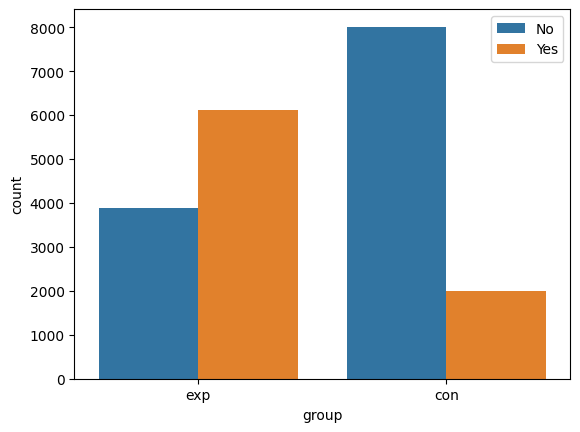

In [18]:
sns.countplot(x='group', data=df_ab_test, hue='click')
plt.legend(labels=['No', 'Yes'])

It is clear from the plot that the number of clicks in the experimental group is larger. This is of course an exagerated example as it is simulated just for the purpose of learning. 

# Parameters of the model from the power analysis

- Beta: Probability of making type II error (fail to reject null hypothesis when it is actually wrong)
- 1 - Beta: power of test
- Alpha: Probability of making type I error, significance level. We are comfortable of making error type 1 which is rejecting null hypothesis when it is actually true.
- Delta: Minimum detectable effect. So if it the effect is there and version B is better, but how much improvement we should see in order to make sense for the bussiness to implement the change

In [19]:
alpha = 0.05 
print("Alpha: significance level is:", alpha)

delta = 0.1
print("Delta: minimum detectable effect is:", delta)

Alpha: significance level is: 0.05
Delta: minimum detectable effect is: 0.1


# Calculatin total numer of clicks per group by summing clicks

In [44]:
X_con = df_ab_test.groupby('group')['click'].sum().loc['con']
X_exp = df_ab_test.groupby('group')['click'].sum().loc['exp']

N_con = df_ab_test[df_ab_test['group']=="con"].shape[0]
N_exp = df_ab_test[df_ab_test['group']=="exp"].shape[0]

print("number of clicks in control group:", X_con)
print("number of clicks in the experiment group:", X_exp)
print("total number of clicks:", X_con + X_exp )

number of clicks in control group: 1989
number of clicks in the experiment group: 6116
total number of clicks: 8105


# Calcualte the pooled prob and variance

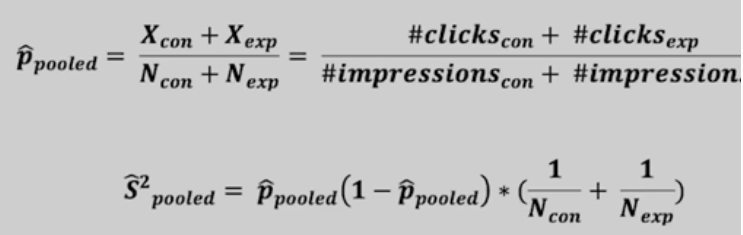

In [49]:
p_con = X_con / N_con
p_exp = X_exp / N_exp

print( p_con, p_exp)

p_pooled = (X_con + X_exp) / (N_con + N_exp)
print("Pooled prob:", p_pooled)

0.1989 0.6116
Pooled prob: 0.40525


In [51]:
pooled_var = p_pooled * (1 - p_pooled) * (1/N_con + 1/N_exp)
print(pooled_var)

4.82044875e-05


# Computing the standard error and test statistics

for the test statistics: 

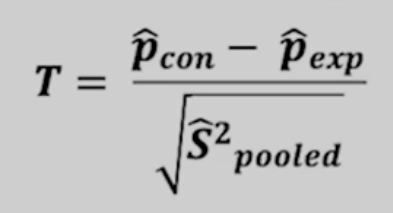

In [56]:
SE = np.sqrt(pooled_var)
print(SE)

0.006942945160376826


In [57]:
# test statistics for Z_test
test_stat = (p_con - p_exp) / SE
print("Test statistics for 2-sample Z-test is:", test_stat)

Test statistics for 2-sample Z-test is: -59.44163326469381


In [58]:
# critical value of the Z-test
Z_critical = norm.ppf(1-alpha/2)
print("Z-critical value from standard noral distibution:", Z_critical)

Z-critical value from standard noral distibution: 1.959963984540054


This value was obvious even before computing it. from the Z table

# Calculating p_values of the Z_test

- A low p-value indicates stron evidence againt the null hypothesis, so we reject the null hypothesis
- A high p-value indicates weak evidence againat the null hypothesis, we we fail to reject the null hypothesis

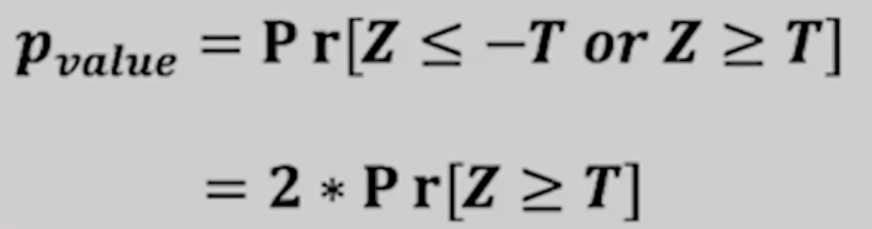

In [60]:
p_value = 2 * norm.sf(abs(test_stat))
p_value

np.float64(0.0)

So the P_value is so so small that it is almost zero. So we can reject the null hypothesis and there is strong evidence that there is stron evidence that p_con and p_exp are different and in this case p_exp is larger significanly

# Lets also visualize the results

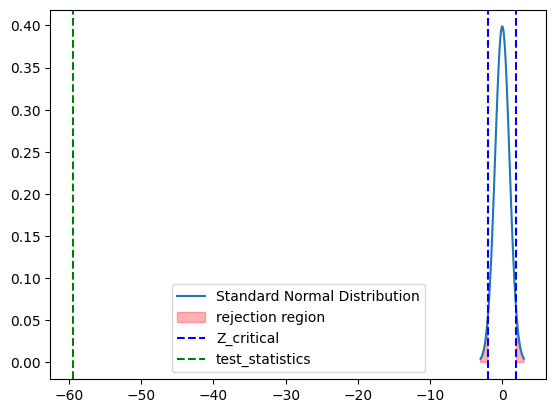

In [74]:
# for visualization we are going to use the standard normal distribution

mu = 0
sigma = 1
x = np.linspace(mu - 3 * sigma , mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, label = 'Standard Normal Distribution')
# Shade the rejection region for a two-tailed test

plt.fill_between(x, y, where = (x > Z_critical)| (x< -Z_critical), color = 'red', alpha = 0.3, label = 'rejection region')

#adding test statistics
plt.axvline(Z_critical, color='blue', linestyle = 'dashed', label='Z_critical')
plt.axvline(-Z_critical, color='blue', linestyle = 'dashed')

plt.axvline(test_stat, color='green', linestyle = 'dashed', label='test_statistics')
plt.legend()



# Computing the confidence interval

We need to do this becasue we want to see if it is practically worth to implement the change or not. For that we first need to find the confidence interval (CI)

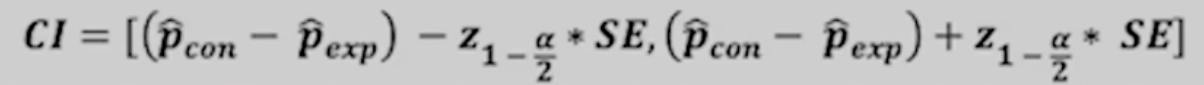

In [76]:
CI = [ 
    round((p_exp - p_con) - SE * Z_critical, 3) , # round to 3 decimal places
    round((p_exp - p_con) + SE * Z_critical, 3)
]

print(CI)

[np.float64(0.399), np.float64(0.426)]


# Testing for practical significance in AB testing

If the lower bound of the confidence interval is lower than the Minimum detectable effect that we set at the beggining of the hypothesis, then we say that the test is practically significant and it makes sense for the buissiness to implement this change. For example at the bggining we decide an MDE of 0.1, and our lower CI is ~ 0.04, therefore 0.04 < 0.1 which means it is practically significant for the bussiness to implement this changes 

# Summary

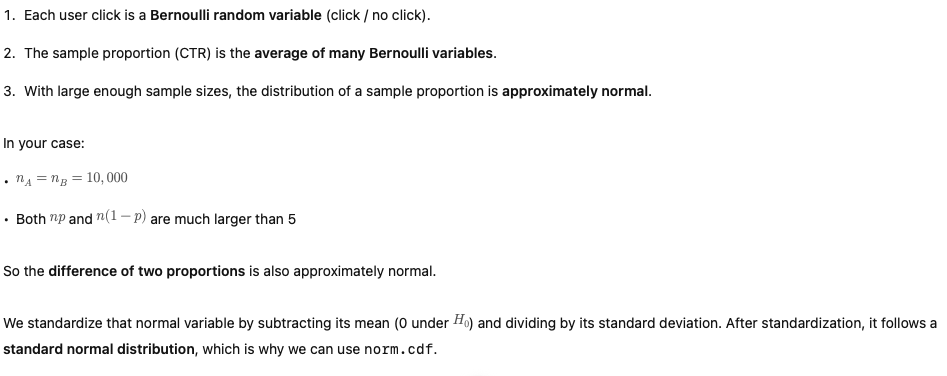

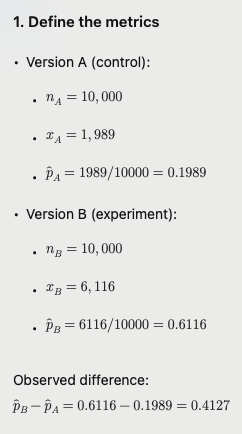

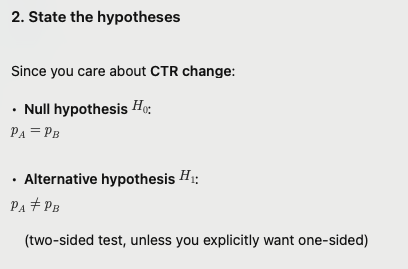

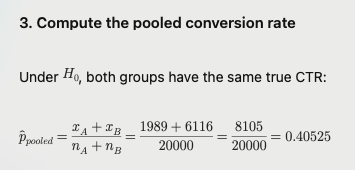

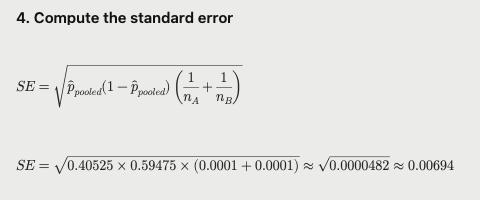

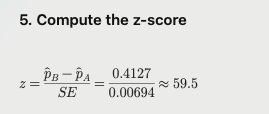

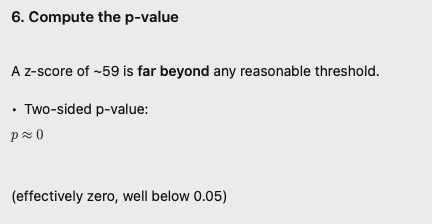

In case you dont have a table to look up the p_value. It can be computed like this:

 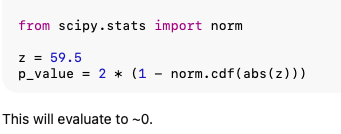

 norm.cdf(x) is the area under the standard normal curve to the left of x.

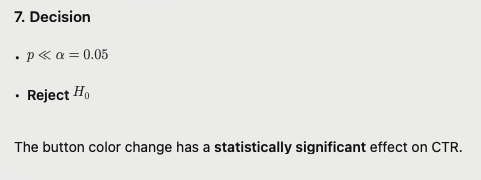

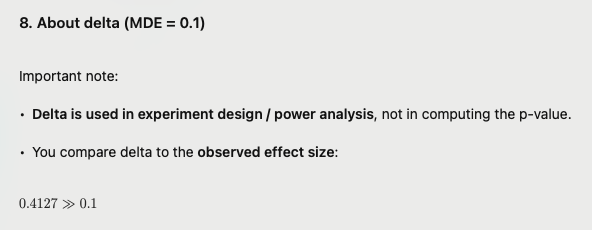

# How to compute the sample size for an AB test:

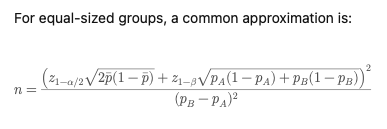
